# COM-308 Introduction to quantum computation [Spring 2024]
## Mini-project: Grover's algorithm applied to a satisfiability problem

### Q0: Finding all the solutions

In [1]:
import sympy 
from sympy import symbols
from sympy.logic.boolalg import truth_table
from IPython.display import display, Math

x = symbols('x:5')
x0, x1, x2, x3, x4 = x
x_i_to_i = {x[i]: i for i in range(len(x))}
f = (~x0 | x1) & (x0 | x1 | ~x2) & (x2 | x3) & (~x1 | ~x2 | x3) & (~x3 | ~x4) & (~x2 | ~x3 | x4)
f

(x2 | x3) & (x1 | ~x0) & (~x3 | ~x4) & (x0 | x1 | ~x2) & (x3 | ~x1 | ~x2) & (x4 | ~x2 | ~x3)

In [2]:
solutions = []
for x_vals, res in truth_table(f, x):
    if res:
        solutions.append(''.join(map(str, x_vals)))

n_solutions = len(solutions)
print('Number of solutions:', n_solutions)
for sol in solutions:
    display(Math(', '.join([f'{var} = {val}' for var, val in zip(map(sympy.latex, x), sol)])))
    # display(x0 == 1Math(sol))

Number of solutions: 3


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Note: the simplified formula then would be:

In [3]:
from sympy.logic import simplify_logic
simplify_logic(f)

x3 & ~x2 & ~x4 & (x1 | ~x0)

## Working with quantum circuit

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

from qiskit_ibm_runtime import QiskitRuntimeService



### Q1: Design the state preparation circuit

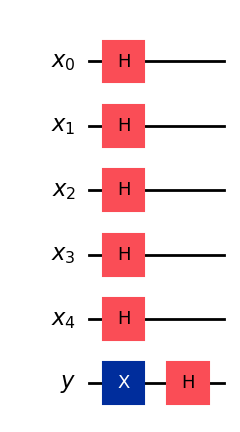

In [5]:
n_qubits_input = len(x) 

xr = QuantumRegister(n_qubits_input, name='x')
yr = QuantumRegister(1, name='y')

state_preparation_circuit = QuantumCircuit(xr, yr, name='state_prep')
state_preparation_circuit.h(xr)
state_preparation_circuit.x(yr)
state_preparation_circuit.h(yr)
state_preparation_circuit.draw('mpl')

### Q2: Design oracle

Application of De Morgan's law to disjunction clauses:
 $$\begin{aligned}
 \lnot x_0 \lor x_1  &= \lnot (x_0 \land \lnot x_1) \\
 x_0 \lor x_1 \lor \lnot x_2  &= \lnot ( \lnot x_0 \land \lnot x_1 \land x_2 )  \\
 x_2 \lor x_3 &= \lnot ( \lnot  x_2  \land \lnot x_3  )  \\
 \lnot x_1 \lor \lnot x_2 \lor x_3 &=   \lnot (x_1 \land  x_2  \land \lnot x_3  )  \\
 \lnot x_3 \lor \lnot x_4 &= \lnot ( x_3  \land   x_4 )  \\
 \lnot x_2 \lor \lnot x_3 \lor x_4 &= \lnot ( x_2   \land x_3 \land  \lnot x_4 )
\end{aligned}$$

We can perform the construction manually, however, here we automate the process.

In the following piece of code, `sympy` expression is dissected. First, we create list `oracle_structure`; each element of it corresponds to one of disjunctions. This element consists of two lists: the first specifies on which variables we add controls, the second specifies which of them we have to negate (i.e. those which are not negated in original disjunction).

In [6]:
def clauses_CNF(expr) -> tuple:
    if not isinstance(expr, sympy.logic.boolalg.And):
        return expr,
    return expr.args

def clauses_DNF(expr) -> tuple:
    if not isinstance(expr, sympy.logic.boolalg.Or):
        return expr,
    return expr.args

def is_negated(expr) -> tuple:
    # Returns if the variable was negated and the variable itself
    if len(expr.args) == 0:
        return False, expr
    return True, expr.args[0]

oracle_structure = []
for disj in clauses_CNF(f):
    inds_control = []
    inds_to_negate = []
    for x_i_expr in clauses_DNF(disj):
        x_i_is_negated, x_i = is_negated(x_i_expr)
        i = x_i_to_i[x_i]
        inds_control.append(i)
        if not x_i_is_negated:
            inds_to_negate.append(i)
    oracle_structure.append((inds_control, inds_to_negate))

Using this info, we can build an oracle:

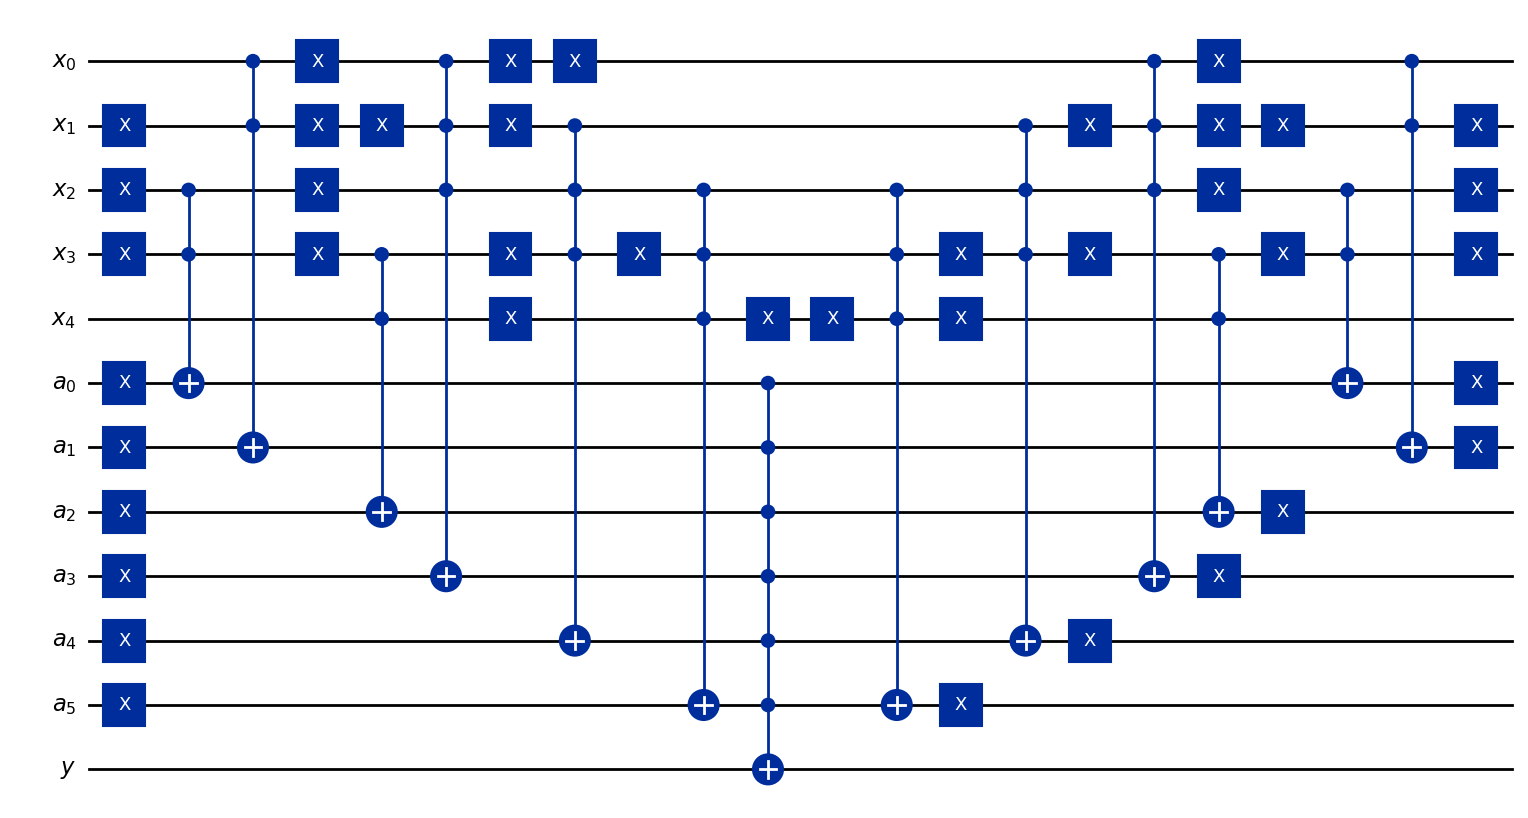

In [7]:
n_clauses = len(oracle_structure)
ar = QuantumRegister(n_clauses, name='a') 
U_f = QuantumCircuit(xr, ar, yr, name="U_f")

U_f.x(ar)

for ind_clause, (inds_control, inds_to_negate) in enumerate(oracle_structure): 
    for i in inds_to_negate:
        U_f.x(xr[i])
    U_f.mcx([xr[i] for i in inds_control], ar[ind_clause])
    for i in inds_to_negate:
        U_f.x(xr[i])

U_f.mcx(ar, yr)

# returning ancillas to original state
for ind_clause, (inds_control, inds_to_negate) in reversed(list(enumerate(oracle_structure))): 
    for i in inds_to_negate:
        U_f.x(xr[i])
    U_f.mcx([xr[i] for i in inds_control], ar[ind_clause])
    for i in inds_to_negate:
        U_f.x(xr[i])
    
U_f.x(ar)

U_f.draw('mpl')

### Q3: Design the reflection operator

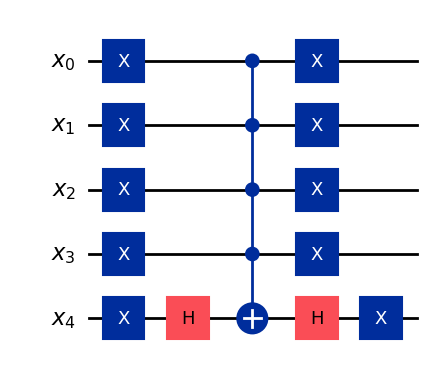

In [8]:
R = QuantumCircuit(xr, name='R')
R.x(xr)
R.h(xr[-1])
R.mcx(xr[:-1], xr[-1])
R.h(xr[-1])
R.x(xr)
R.draw('mpl')

We can validate this operator indeed represents $U = \mathbb{I} - 2 \left|0\dots0\right\rangle\left\langle0\dots0\right|$

In [9]:
from qiskit.quantum_info.operators import Operator

R_ref = np.eye(2 ** n_qubits_input)
R_ref[0, 0] -= 2
np.allclose(R_ref, Operator(R).data.real)

True

Now, we just add Hadamard gates:

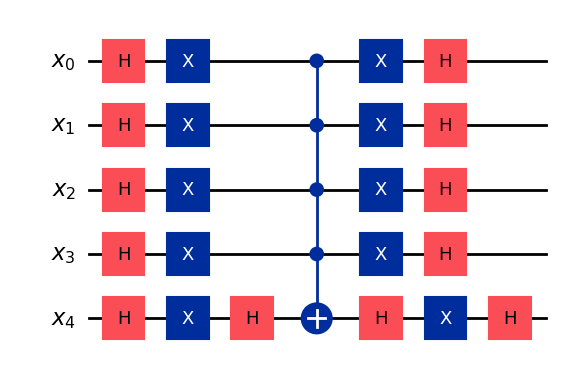

In [10]:
R_H = QuantumCircuit(xr, name='R_H')
R_H.h(xr)
R_H.compose(R, inplace=True)
R_H.h(xr)
R_H.draw('mpl')

### Q4: run Grover's algorithm:

First, we build Grover's operator:

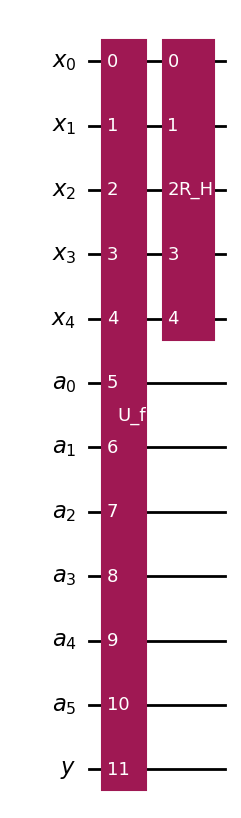

In [11]:
G = QuantumCircuit(xr, ar, yr, name='G')
G.append(U_f, list(xr) + list(ar) + list(yr)) 
G.append(R_H, xr) 
G.draw('mpl')

Now, we build the whole circuit:

In [12]:
cr = ClassicalRegister(n_qubits_input)

grover_circuits = []
k_max_val = 4
for k in range(1, k_max_val + 1):
    grover_circuit_k = QuantumCircuit(xr, ar, yr, cr)
    grover_circuit_k.append(state_preparation_circuit, list(xr) + list(yr))
    for _ in range(k):
        grover_circuit_k.append(G, list(xr) + list(ar) + list(yr))

    for i in range(n_qubits_input):
        grover_circuit_k.measure(xr[i], i)
    
    grover_circuits.append(grover_circuit_k)

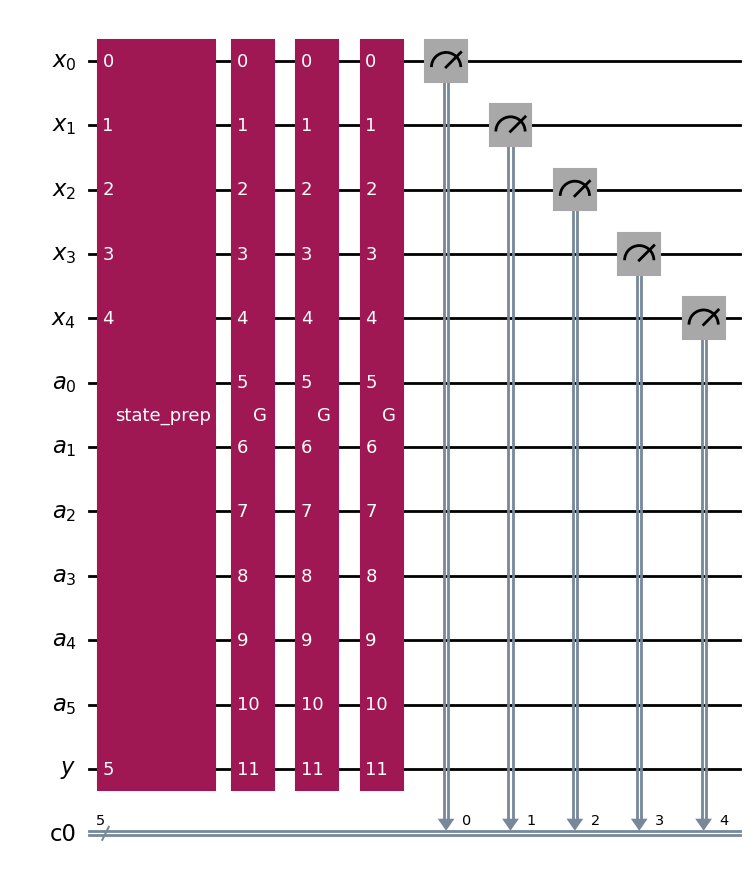

In [13]:
# Draw circuit where Grover's operator is applied 3 times
grover_circuits[2].draw('mpl')

First of all, we run the circuit on the perfect simulator:

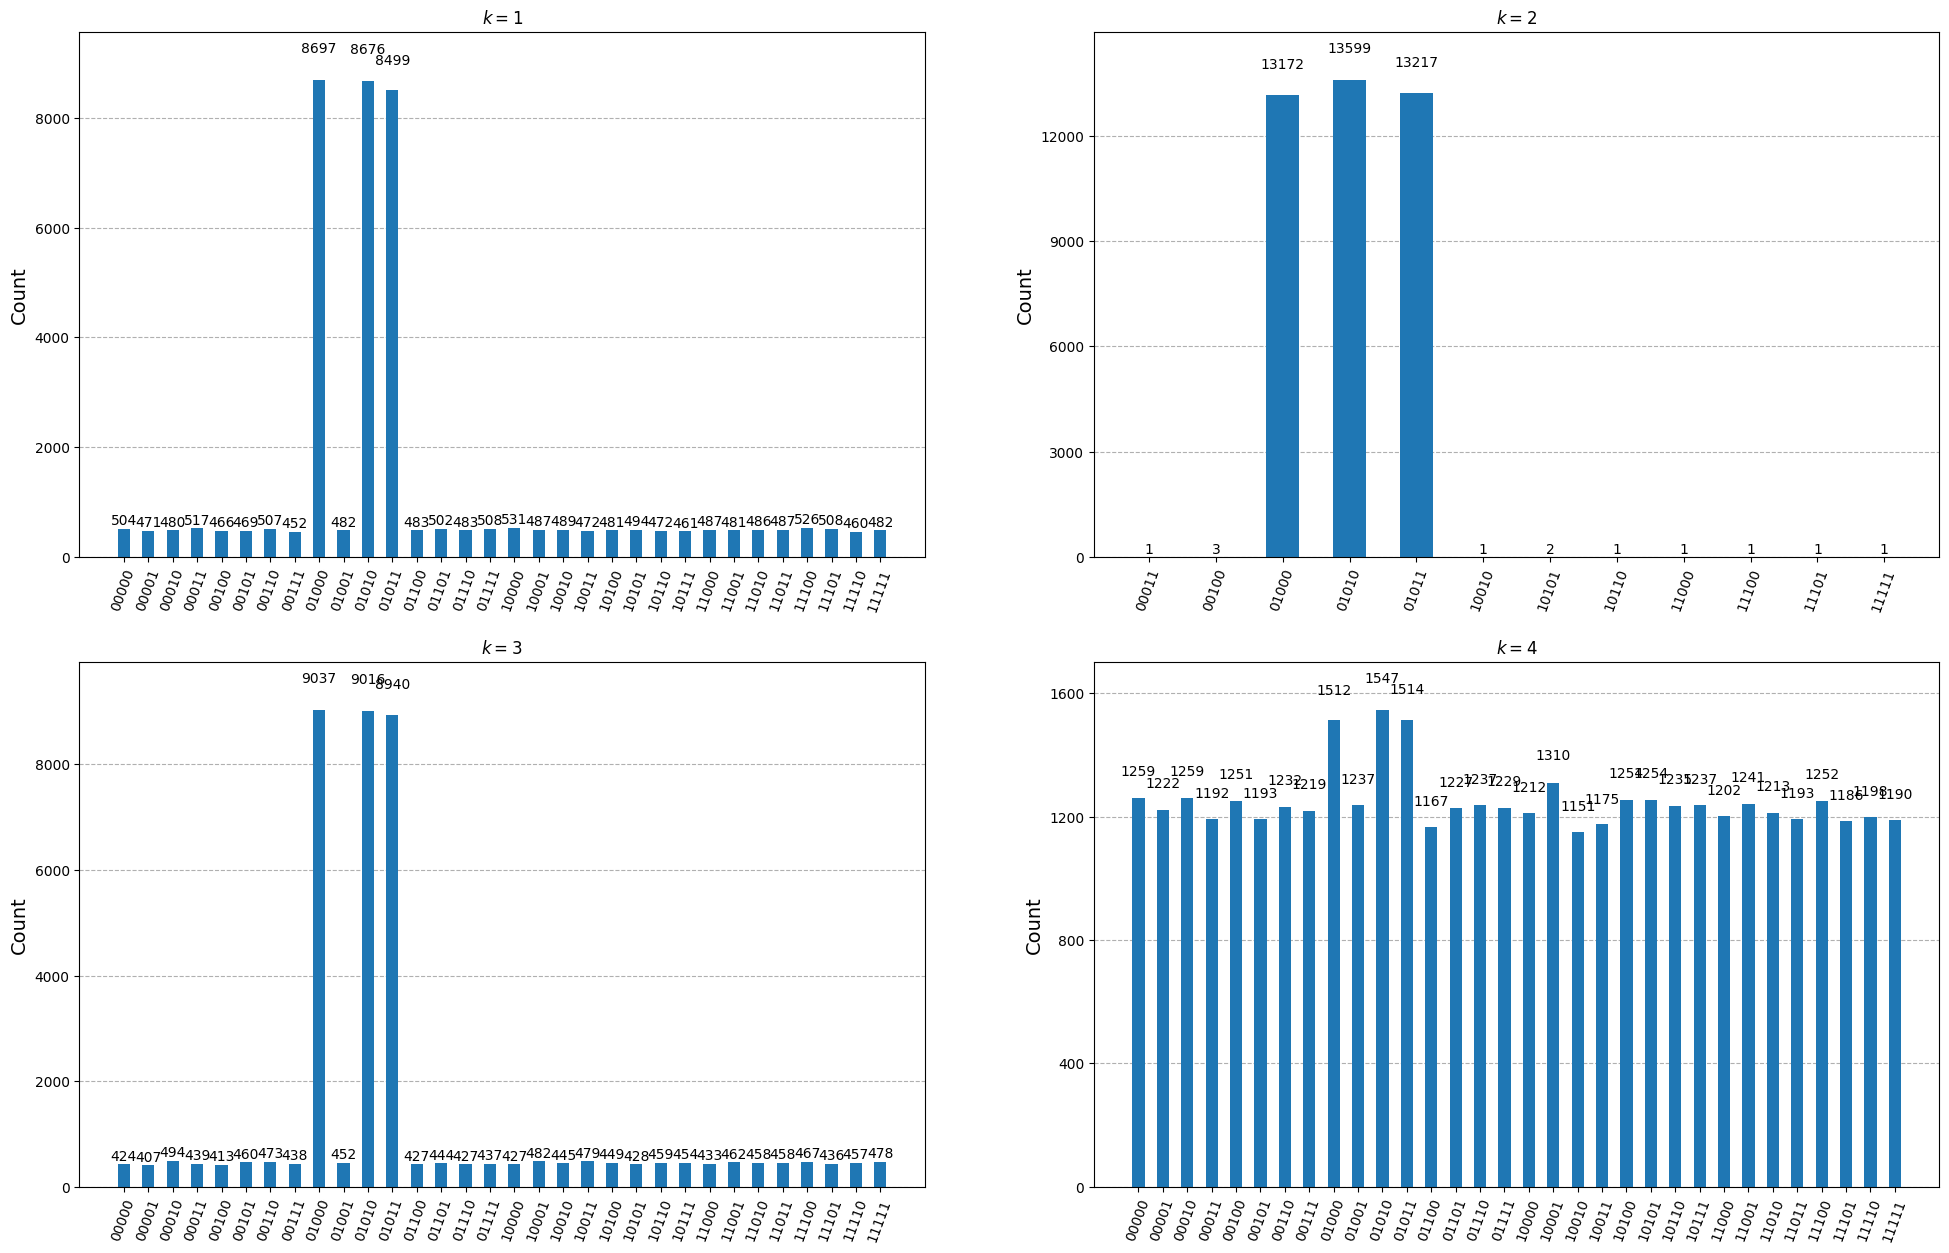

In [14]:
sim_ideal = AerSimulator()
fig, axs = plt.subplots(2, 2, figsize=(24, 15))

for k, grover_search_circuit in enumerate(grover_circuits):
    grover_isa = transpile(grover_search_circuit, sim_ideal)
    search_res = sim_ideal.run(grover_isa, shots=40000).result().get_counts()
    
    plot_histogram(search_res, ax=axs[k // 2, k % 2])
    axs[k // 2, k % 2].set_title(f'$k = {k + 1}$')
    axs[k // 2, k % 2].grid(axis="y", ls="--")

plt.show()

As we know from the lectures, we obtain solutions with a total probability of $\sin^2 \left( (2 k + 1) \theta_0 \right)$, each equally likely, and non-solutions with a total probability of $ \cos^2 \left( (2 k + 1) \theta_0 \right)$, each also equally likely. The value of the initial angle $\theta_0 \approx 0.31$ is computed in Q5. This is confirmed by the histograms above.

To proceed, we instantiate an interface for the IBM Quantum backend.

In [15]:
service = QiskitRuntimeService()
backend = service.backend("ibm_osaka")  # least busy at point of writing this solution

Then, for better comparison between noisy simulator and real machine, we transpile the circuits according to the backend architecture before the simulation with noise (and, of course, the launch on real machine). This helps to eliminate the discrepancy of results due to randomness in the transpilation process.

In [16]:
grover_circuits_transpiled = [transpile(circ, backend) for circ in grover_circuits]

Now, we instantiate a noisy simulator modelling the backend and run the circuits on it.

In [17]:
sim_noisy = AerSimulator.from_backend(backend)

results_sim_noisy = []
for grover_search_circuit in grover_circuits_transpiled[:3]:
    results_sim_noisy.append(sim_noisy.run(grover_search_circuit, shots=4000).result())

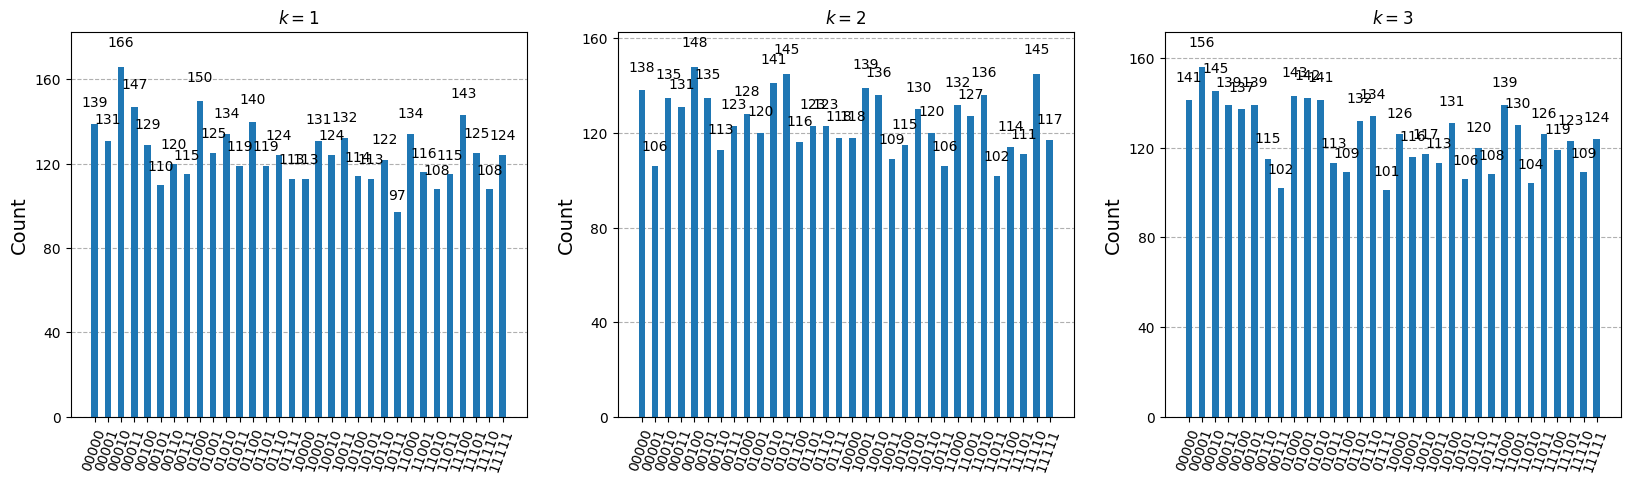

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for k, res in enumerate(results_sim_noisy):
    plot_histogram(res.get_counts(), ax=axs[k])
    axs[k].set_title(f'$k = {k + 1}$')
    axs[k].grid(axis="y", ls="--")

plt.show()

Indeed, we can see noise completely obscuring the signal; this is not surprising if we look at the depth of transpiled circuits:

In [33]:
for k, circ in enumerate(grover_circuits_transpiled, start=1):
    print(f'k = {k}, width = {circ.width()}, depth = {circ.depth()}')

k = 1, width = 132, depth = 2004
k = 2, width = 132, depth = 4213
k = 3, width = 132, depth = 6778
k = 4, width = 132, depth = 8640


**Note:** when you have done the homework, you might have observed a different, more optimistic picture. This could happen if you transpiled the circuit according to the simulator with a noise model of the backend, instead of backend itself, like:

In [31]:
from qiskit_aer.noise import NoiseModel

noise_model = NoiseModel.from_backend(backend)
sim_noisy_2 = AerSimulator(noise_model=noise_model)

grover_circuits_sim_noisy = [transpile(circ, sim_noisy_2) for circ in grover_circuits]
results_sim_noisy_2 = []

for grover_search_circuit in grover_circuits_sim_noisy[:3]:
    results_sim_noisy_2.append(sim_noisy_2.run(grover_search_circuit, shots=4000).result())

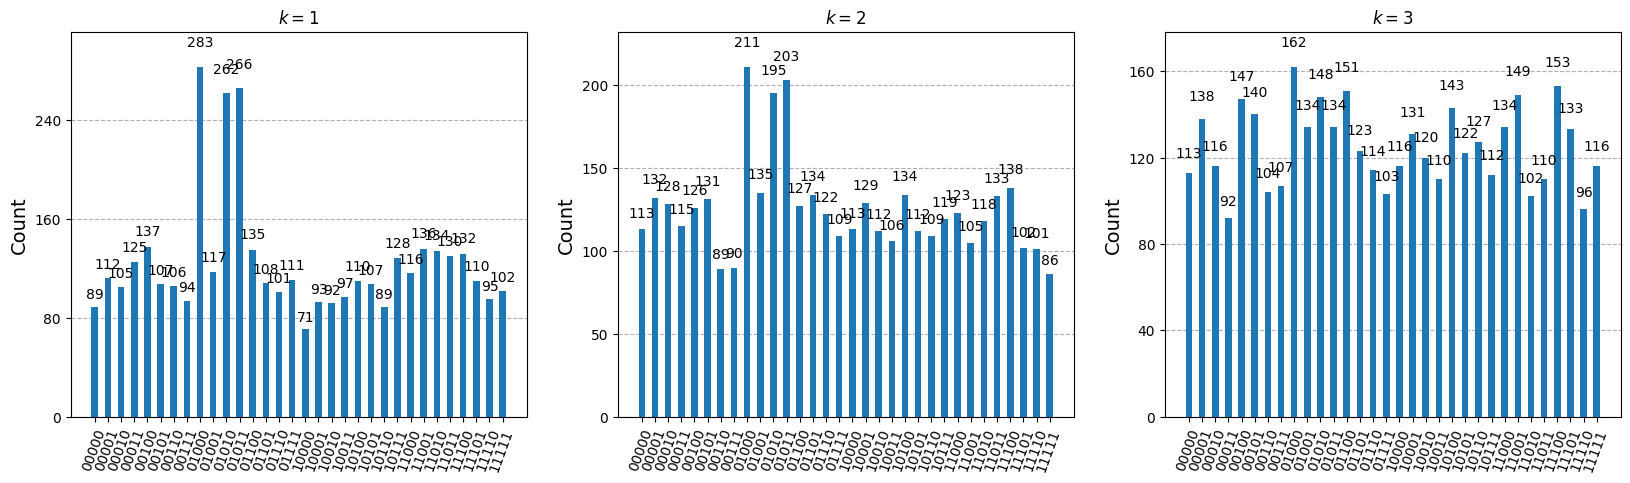

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for k, res in enumerate(results_sim_noisy_2):
    plot_histogram(res.get_counts(), ax=axs[k])
    axs[k].set_title(f'$k = {k + 1}$')
    axs[k].grid(axis="y", ls="--")

plt.show()

Here, on plots for $k = 1$ and $k = 2$, we see number of occurences for any answer string being higher than for any non-answer string. The reason is that while transpilation have accounted for the allowed gate types, it did not account for the architecture the same way. One of the clues is that the width of the circuit, which is 12 qubits + 5 classical bits, was not changed &mdash; unlike the case above, where width was counted as 127 qubits of the real machine + 5 classical bits. Thus, the depth of the circuits would be ~2 times lower than of the ones adapted to the real machine:

In [34]:
for k, circ in enumerate(grover_circuits_sim_noisy, start=1):
    print(f'k = {k}, width = {circ.width()}, depth = {circ.depth()}')

k = 1, width = 17, depth = 929
k = 2, width = 17, depth = 1847
k = 3, width = 17, depth = 2765
k = 4, width = 17, depth = 3683


Finally, we run the circuit on the real machine:

In [36]:
job_real = backend.run(grover_circuits_transpiled[:2], shots=4000)
results_real = job_real.result()

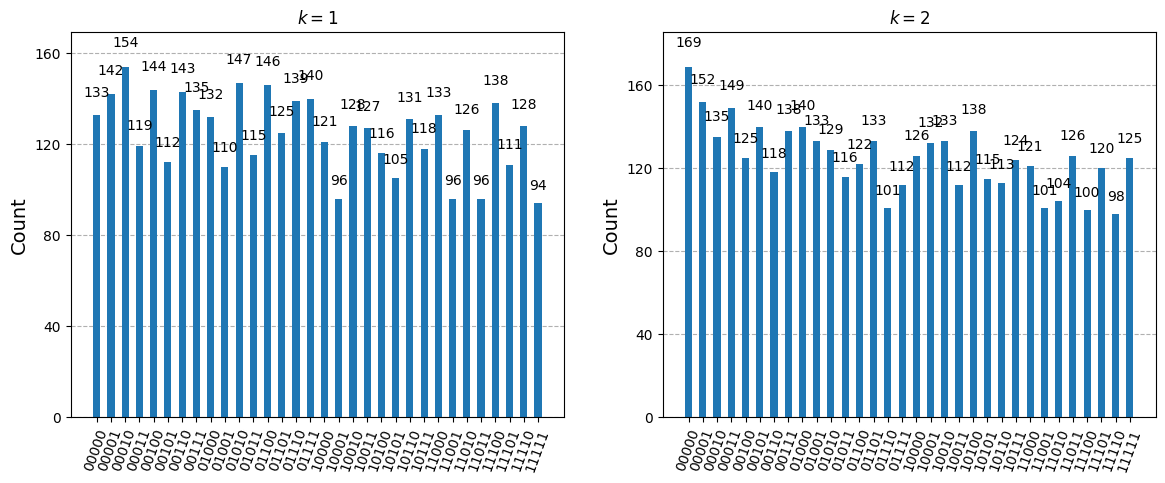

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for k, counts in enumerate(results_real.get_counts()):
    plot_histogram(counts, ax=axs[k])
    axs[k].set_title(f'$k = {k + 1}$')
    axs[k].grid(axis="y", ls="--")

plt.show()

The picture is similar to the one above &mdash; noise close to uniform.

### Q5: Finding $\theta_0$ and best $k$

As we know,
$$\theta_0 = \sqrt{\frac{M}{N}},$$

where $N$ is total number of possible inputs and $M$ is a number of solutions. In our case, $\theta_0 \approx 0.311$:

In [39]:
theta0 = np.arcsin(np.sqrt(n_solutions / 2 ** n_qubits_input))
print(theta0)

0.3111842442775103


Now, our goal is to maximize probability of finding a correct answer, i.e. $\sin^2 \left( (2 k + 1) \theta_0 \right)$. For example, we can see the probabilities for the circuits above:

In [42]:
for k in range(1, 5):
    print(f'k = {k},', f'p_success = {np.sin((2 * k + 1) * theta0) ** 2:0.5f}')

k = 1, p_success = 0.64600
k = 2, p_success = 0.99978
k = 3, p_success = 0.67417
k = 4, p_success = 0.11180


As we can see, $k = 2$ gives 99.9\% chance to get correct answer (under the ideal conditions). In fact, better probability can be achieved only for $k \geq 103$ &mdash; however, this is unreasonable from the perspective of complexity considering we have $N = 32$.

Note that in practice, under some conditions, $k = 1$ may be better than $k = 2$ due to the lower depth of circuit and thus lower complexity and level of noise (as we can see in one of the examples above).

In [44]:
p_ref = np.sin(5 * theta0) ** 2

k = 3
while True:
    p_success = np.sin((2 * k + 1) * theta0) ** 2
    if p_success > p_ref:
        break
    k += 1

print(f'k = {k},', f'p_success = {p_success:0.5f}')

k = 103, p_success = 0.99984
